# Adolph scRNAseq organoids analysis

In [1]:
import anndata
import scanpy as sc
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sc.settings.autosave=True

## Import data

In [2]:
# load samplesheet metadata
pd_meta_dat = pd.read_csv('samplesheet_scrnaseq.csv',
                          index_col='sample')
pd_meta_dat = pd_meta_dat.drop(axis="columns", labels=["fastq_1", "fastq_2"])
for f, sample in zip(pd_meta_dat.index, pd_meta_dat.to_dict(orient="records")):
    print(sample)

{'group': 'Ctrl', 'internal_id': 'P150-Ctrl'}
{'group': 'A8', 'internal_id': 'P168-A8'}
{'group': 'A9', 'internal_id': 'P168-A9'}
{'group': 'A8A9', 'internal_id': 'P168-A8A9'}
{'group': 'Ctrl', 'internal_id': 'P146-Ctrl'}
{'group': 'A8', 'internal_id': 'P146-A8'}
{'group': 'A9', 'internal_id': 'P146-A9'}
{'group': 'A8A9', 'internal_id': 'P146-A8A9'}
{'group': 'A8', 'internal_id': 'P150-A8'}
{'group': 'A9', 'internal_id': 'P150-A9'}
{'group': 'A8A9', 'internal_id': 'P150-A8A9'}
{'group': 'Ctrl', 'internal_id': 'P148-Ctrl'}
{'group': 'A8', 'internal_id': 'P148-A8'}
{'group': 'A9', 'internal_id': 'P148-A9'}
{'group': 'A8A9', 'internal_id': 'P148-A8A9'}
{'group': 'Ctrl', 'internal_id': 'P168-Ctrl'}


In [3]:
# load cellranger .h5 feature matrices
path_list = []
adatas_list = []
n_barcodes_dict = {}
for ind, sample in zip(pd_meta_dat.index, pd_meta_dat.to_dict(orient="records")):

    pathi = f'/Volumes/Samsung_T5/cellranger/sample-{ind}/outs/filtered_feature_bc_matrix.h5'
    path_list.append(pathi)
    dat_l = sc.read_10x_h5(pathi)
    dat_l.var_names_make_unique()
    assert dat_l.obs_names.is_unique
    dat_l.obs = dat_l.obs.assign(**sample)
    adatas_list.append(dat_l)
    
    n_barcodes_dict[sample['internal_id']] = np.shape(dat_l)[0]

adata_v = anndata.concat(adatas_list, index_unique="_")

/Users/vjmarteau/miniconda3/envs/python/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
for int_id in adata_v.obs.internal_id.unique():
    adata_v.obs.loc[adata_v.obs.internal_id == int_id, 'n_barcodes'] = str(n_barcodes_dict[int_id])

In [5]:
adata_v.obs['label'] = adata_v.obs['internal_id'] + '\nn=' + adata_v.obs['n_barcodes'].astype(str)

In [6]:
adata_v.obs.n_barcodes.unique().astype(int).sum()

27051

In [7]:
adata_v.var['MT'] = adata_v.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'MT'
sc.pp.calculate_qc_metrics(adata_v, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)

In [8]:
adata_v.obs.head()

,group,internal_id,n_barcodes,label,n_genes_by_counts,total_counts,total_counts_MT,pct_counts_MT
AAACCCAAGCGTATGG-1_0,Ctrl,P150-Ctrl,1089,P150-Ctrl\nn=1089,4917,32155.0,1000.0,3.109936
AAACGAAAGATAGCAT-1_0,Ctrl,P150-Ctrl,1089,P150-Ctrl\nn=1089,367,555.0,41.0,7.387388
AAAGAACCACCTGCGA-1_0,Ctrl,P150-Ctrl,1089,P150-Ctrl\nn=1089,8264,122299.0,4756.0,3.888830
AAAGGATAGATTGTGA-1_0,Ctrl,P150-Ctrl,1089,P150-Ctrl\nn=1089,382,508.0,14.0,2.755905
AAAGGATAGCCGATTT-1_0,Ctrl,P150-Ctrl,1089,P150-Ctrl\nn=1089,6500,38896.0,1908.0,4.905389


In [ ]:
## Plots

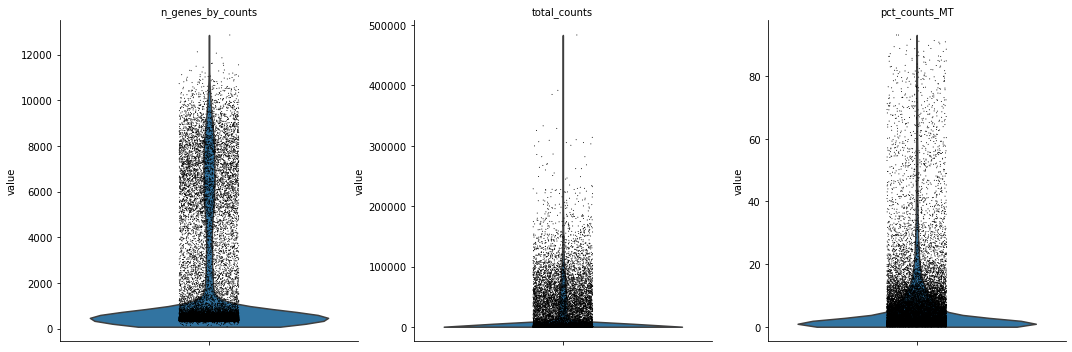

In [9]:
sc.pl.violin(
    adata_v, 
    [
     'n_genes_by_counts', 
     'total_counts', 
     'pct_counts_MT'
     ],
    multi_panel=True
)

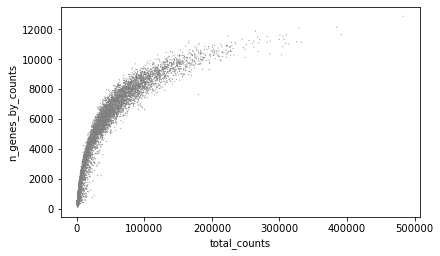

In [10]:
sc.pl.scatter(adata_v, "total_counts", "n_genes_by_counts")

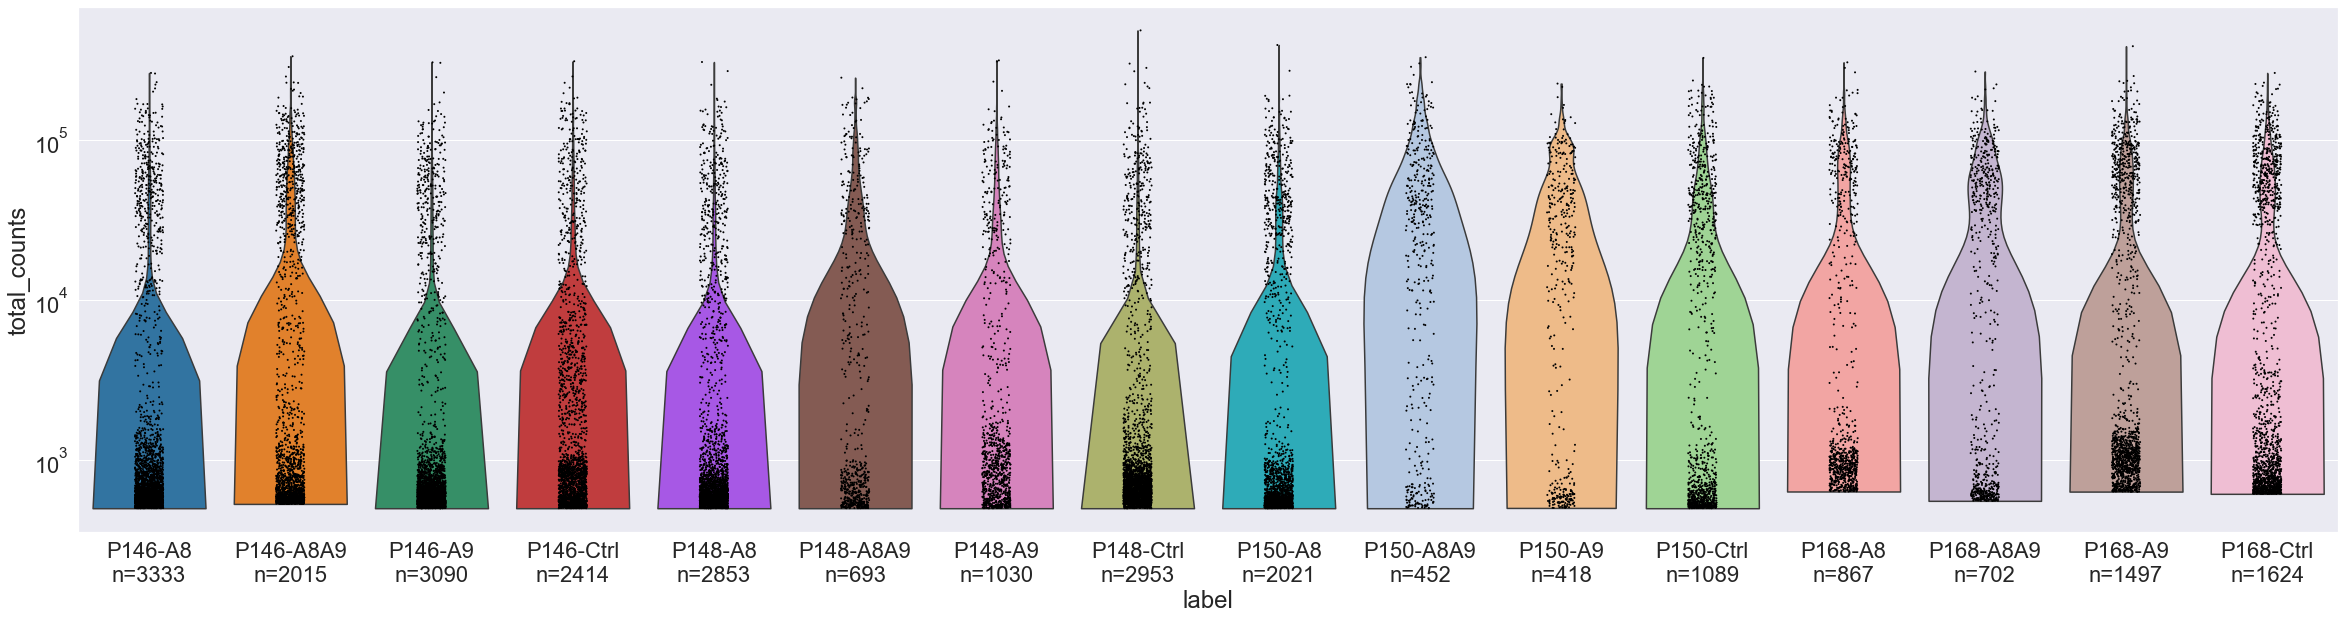

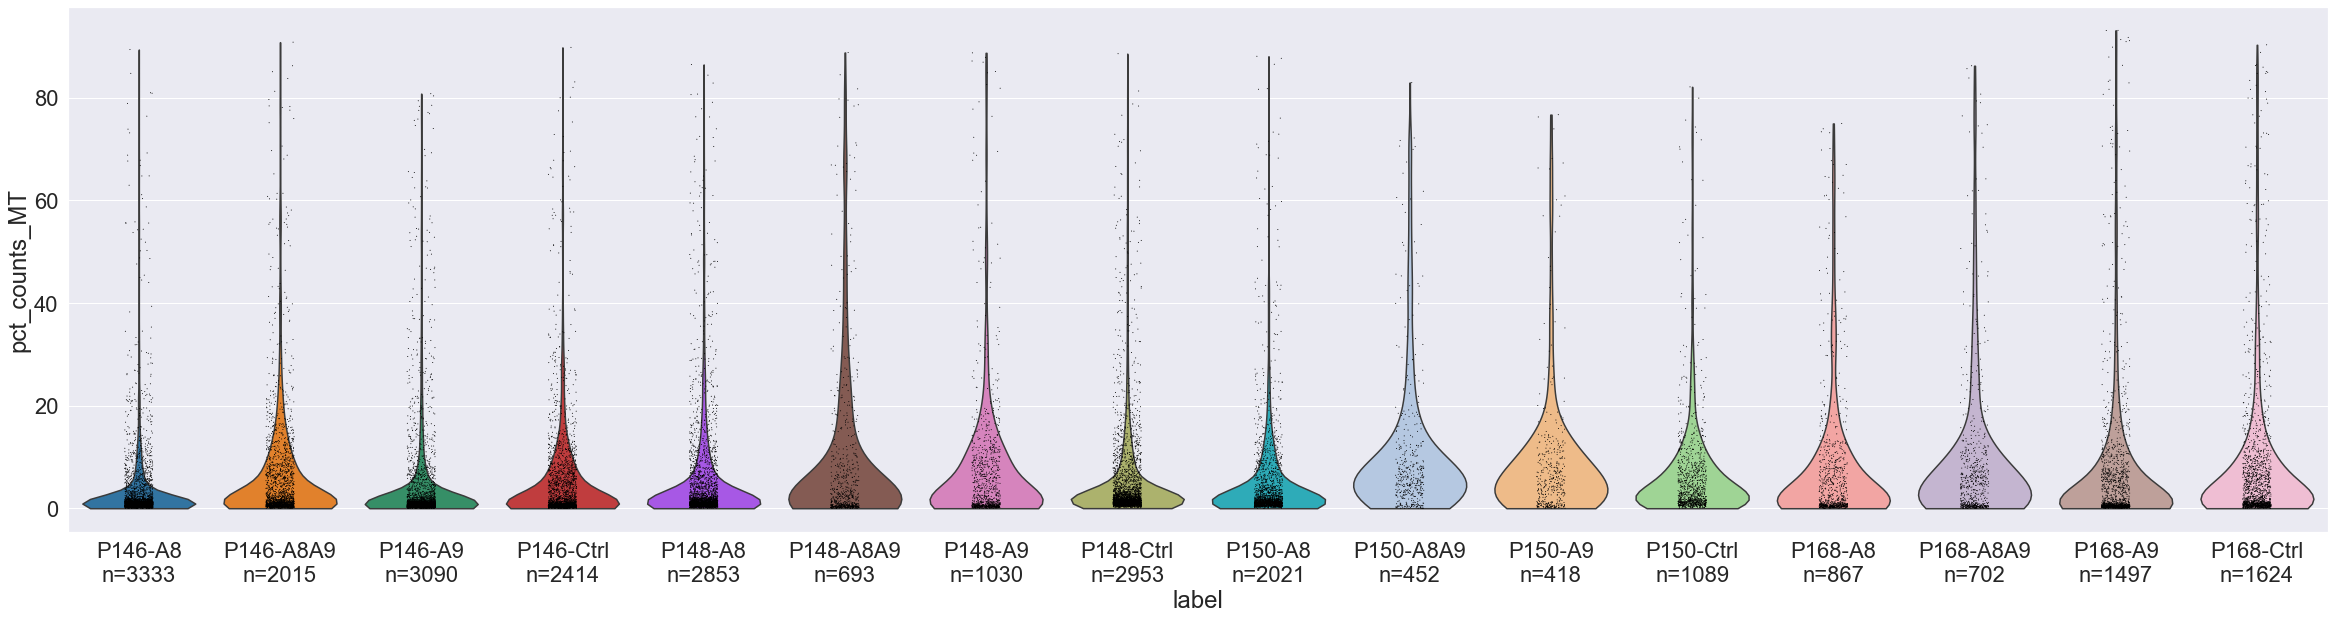

In [11]:
# Quality control - plot QC metrics
#Sample quality plots
sns.set(rc={"figure.figsize":(30,10)})
sns.set(font_scale=2)
t1 = sc.pl.violin(adata_v, 'total_counts', groupby='label', size=2, log=True, cut=0)
#plt.savefig('blub.pdf')
t2 = sc.pl.violin(adata_v, 'pct_counts_MT', groupby='label')

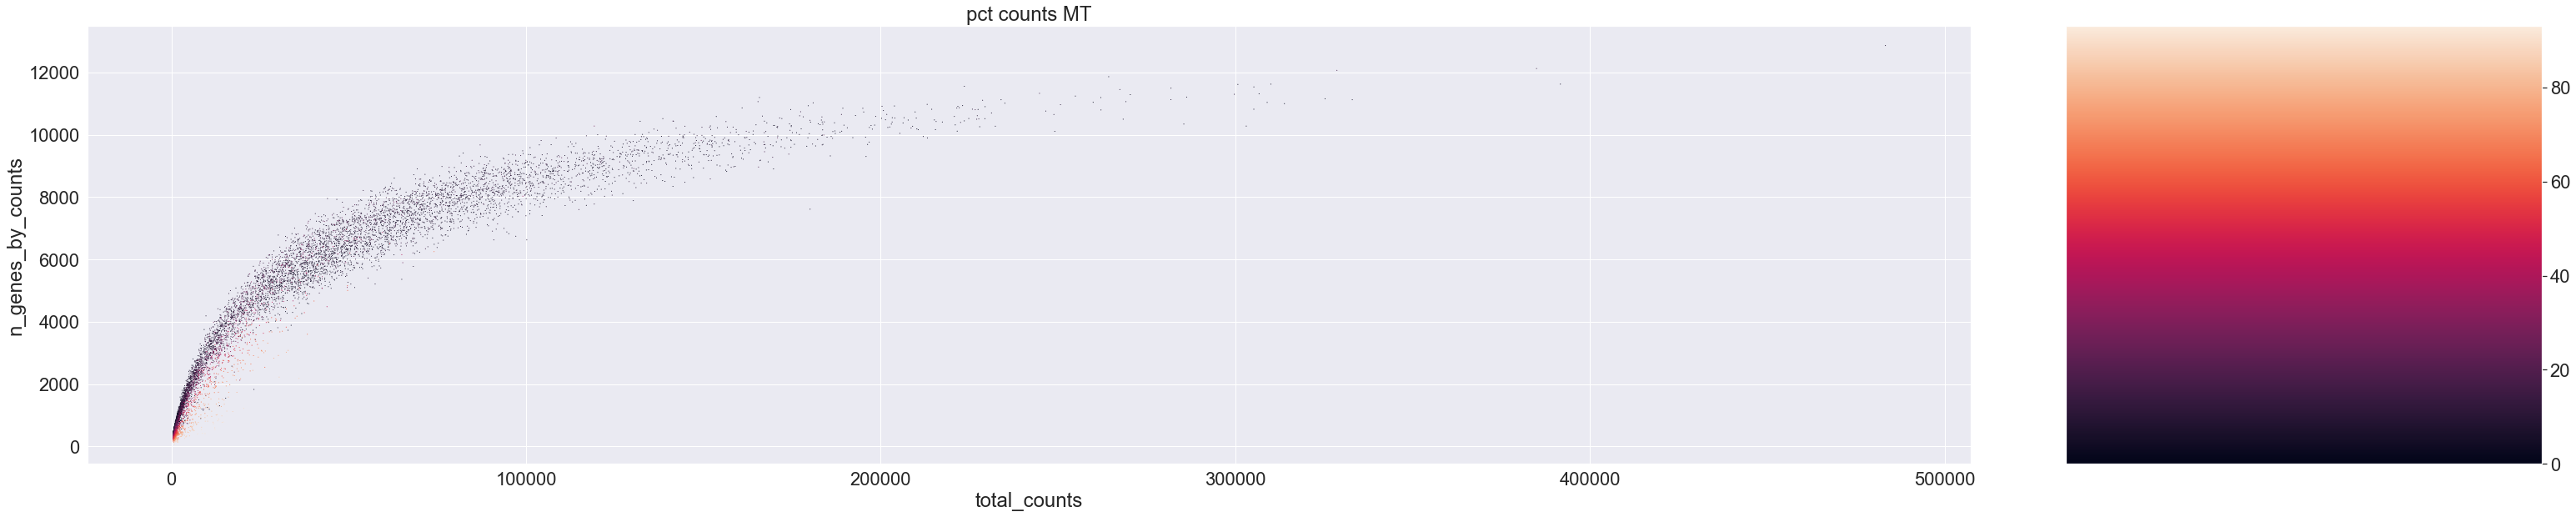

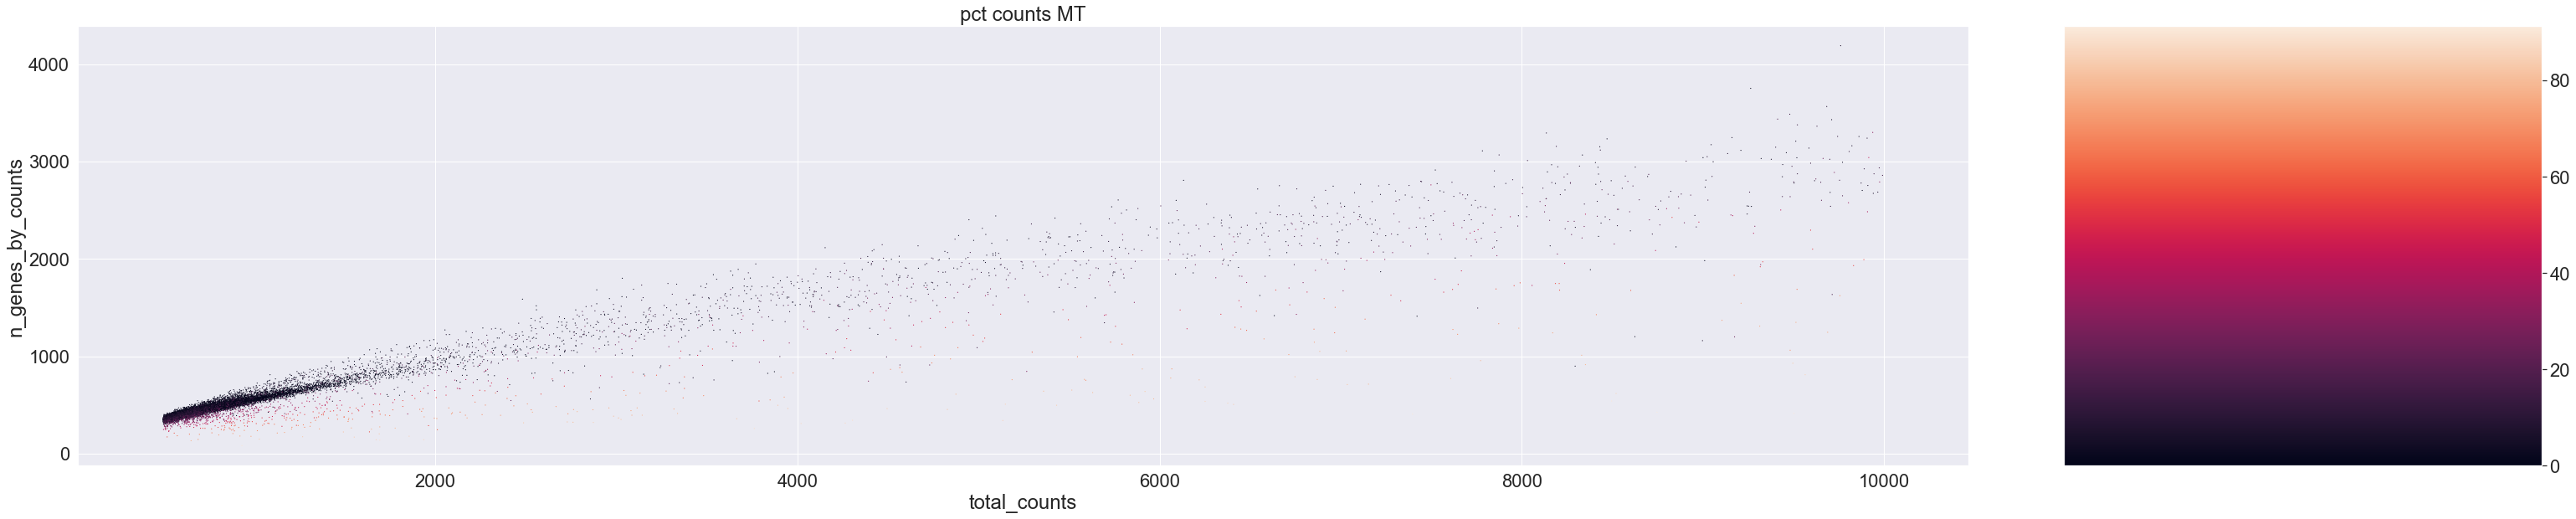

In [12]:
#Data quality summary plots
p1 = sc.pl.scatter(adata_v, 'total_counts', 'n_genes_by_counts', color='pct_counts_MT')
p2 = sc.pl.scatter(adata_v[adata_v.obs['total_counts']<10000], 'total_counts', 'n_genes_by_counts', color='pct_counts_MT')

/Users/vjmarteau/miniconda3/envs/python/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


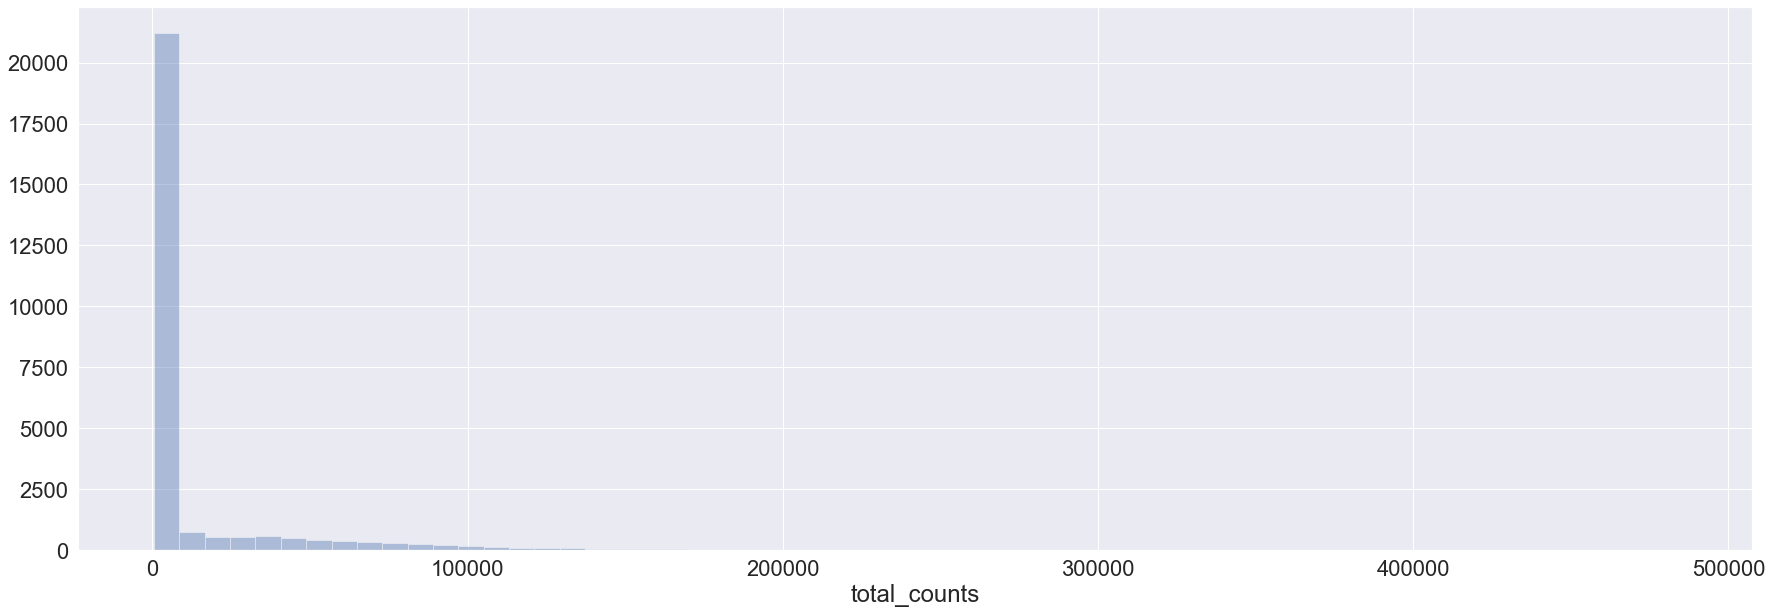

/Users/vjmarteau/miniconda3/envs/python/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


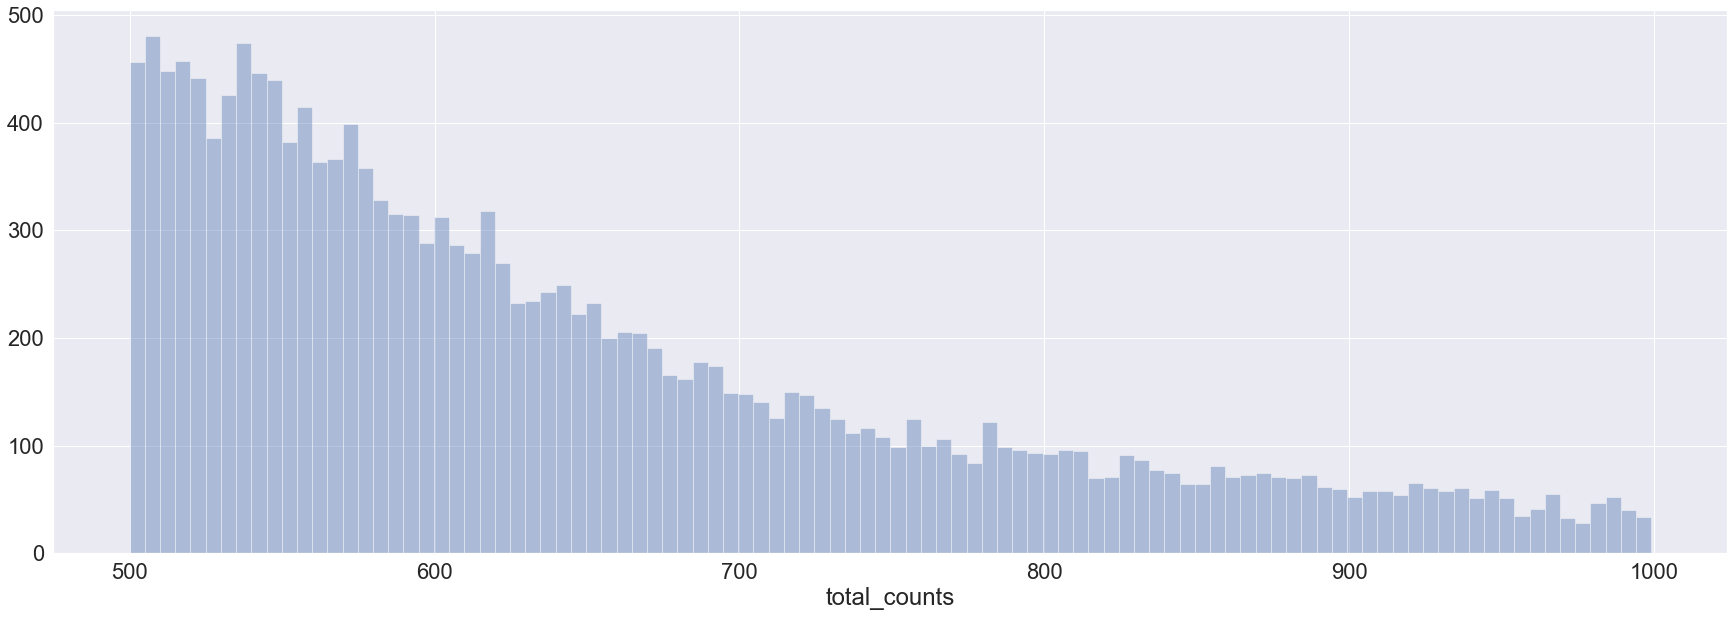

/Users/vjmarteau/miniconda3/envs/python/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


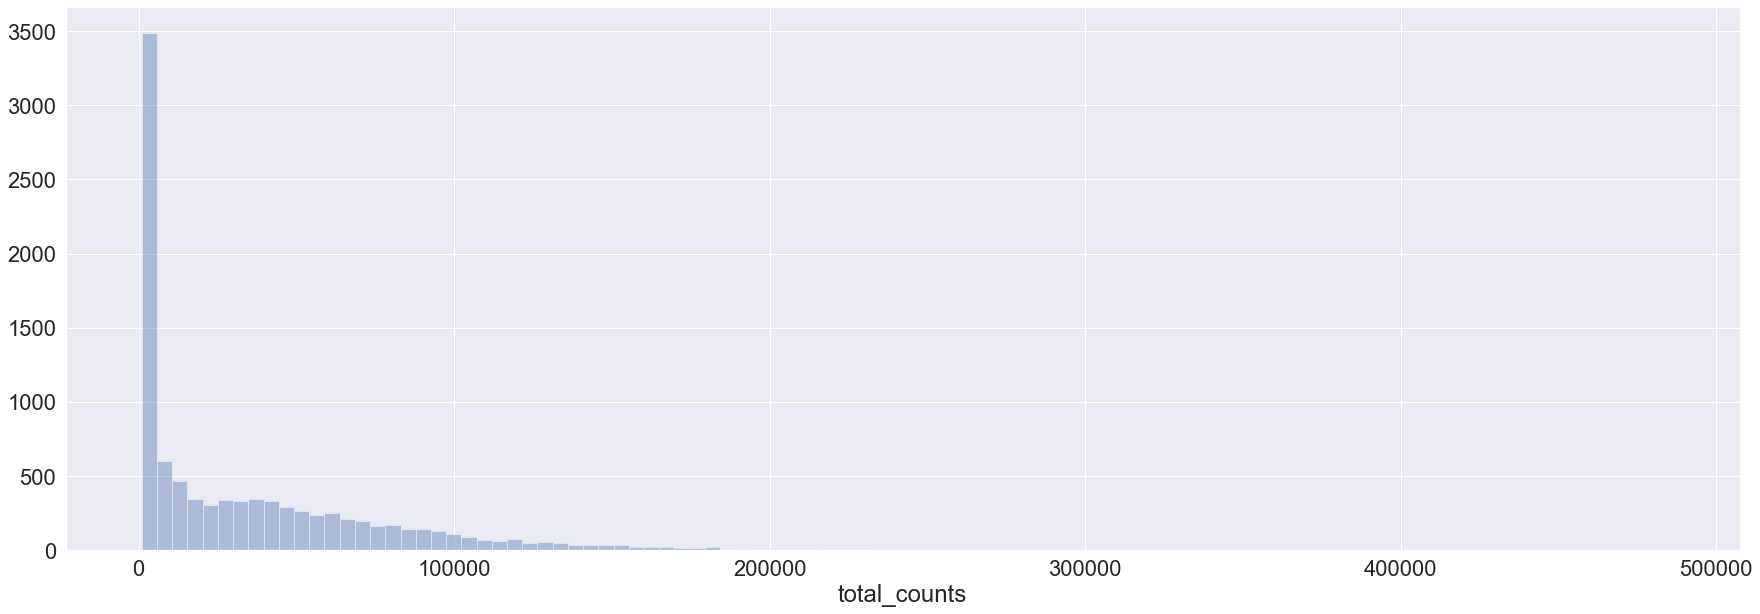

In [13]:
#Thresholding decision: counts
p3 = sns.distplot(adata_v.obs['total_counts'], kde=False, bins=60)
plt.show()

p4 = sns.distplot(adata_v.obs['total_counts'][adata_v.obs['total_counts']<1000], kde=False, bins=100)
plt.show()

p5 = sns.distplot(adata_v.obs['total_counts'][adata_v.obs['total_counts']>1000], kde=False, bins=100)
plt.show()

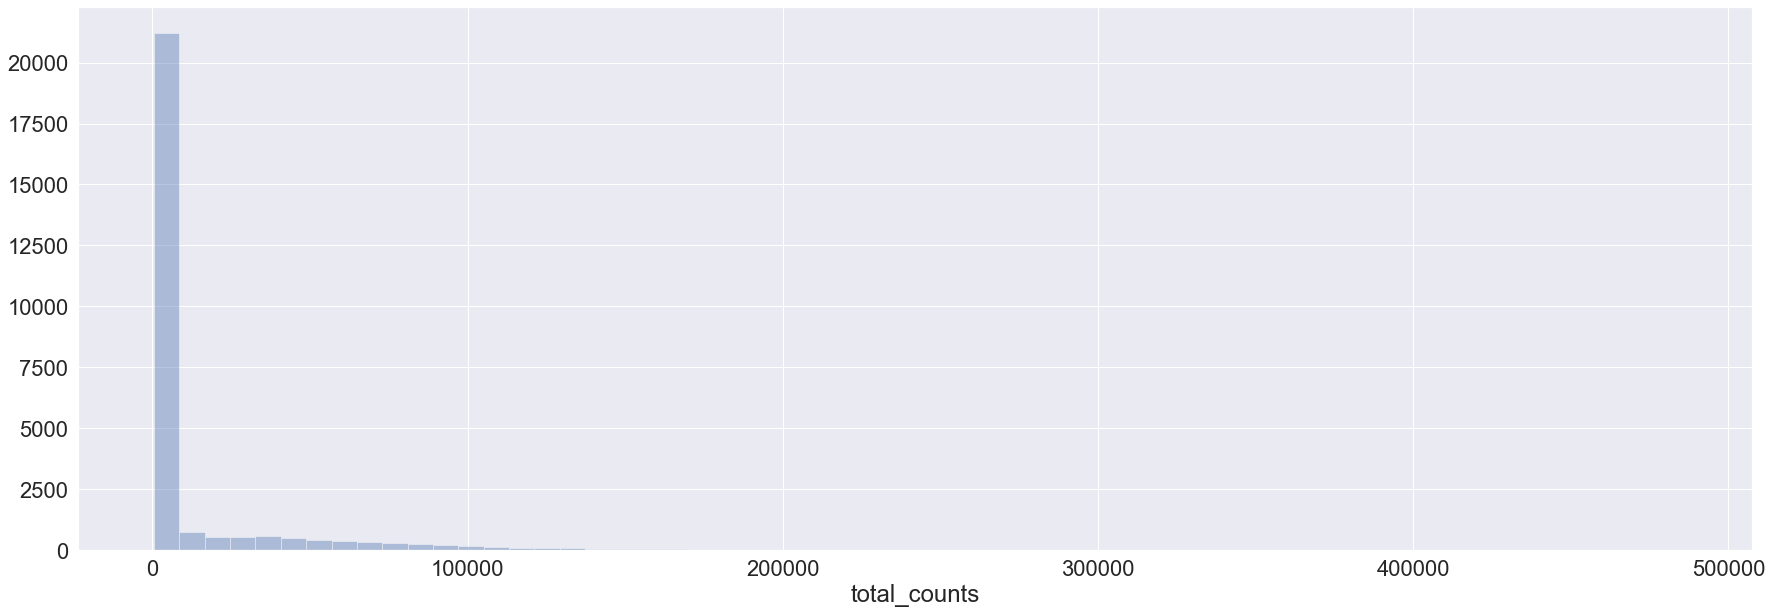

/Users/vjmarteau/miniconda3/envs/python/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


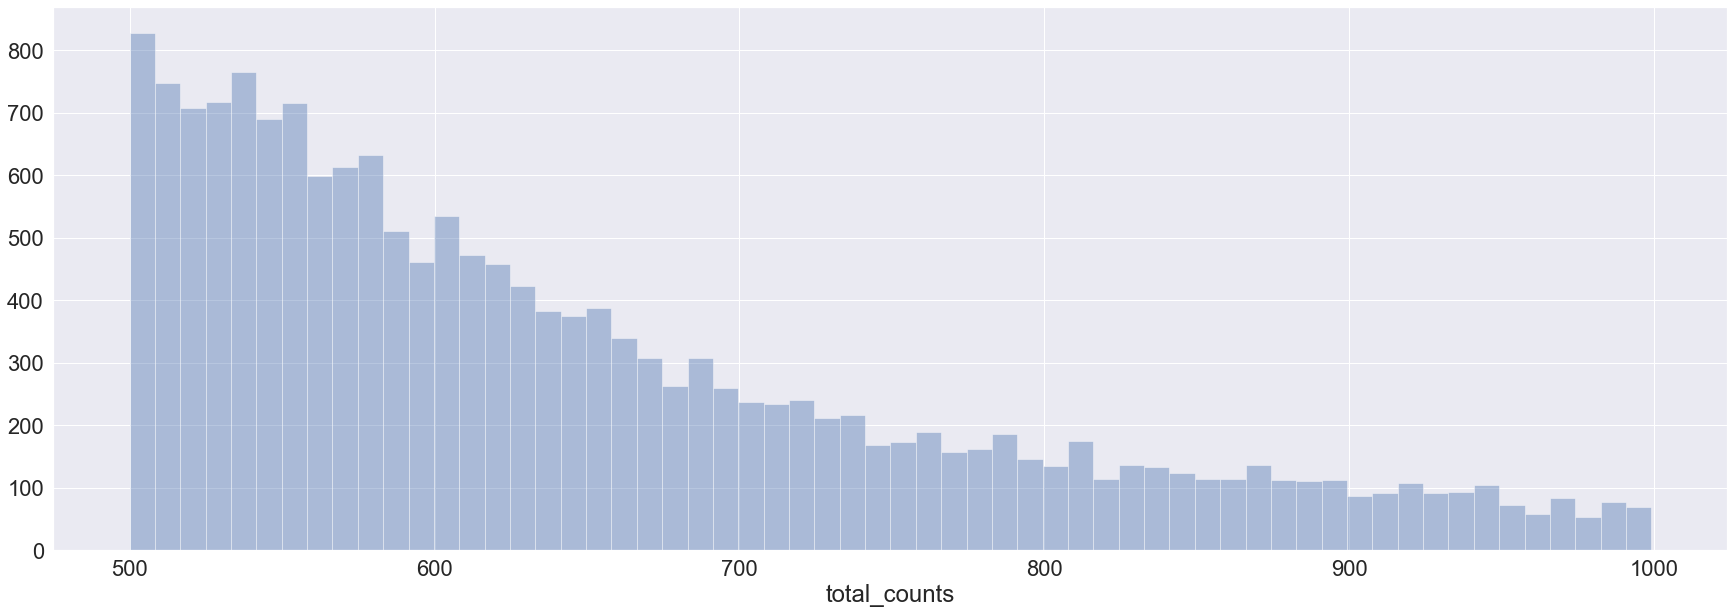

In [14]:
#Thresholding decision: genes
p6 = sns.distplot(adata_v.obs['total_counts'], kde=False, bins=60)
plt.show()

p7 = sns.distplot(adata_v.obs['total_counts'][adata_v.obs['total_counts']<1000], kde=False, bins=60)
plt.show()

In [16]:
adata_v_no_filter = adata_v.copy()

In [17]:
adata_v_no_filter

AnnData object with n_obs × n_vars = 27051 × 36601
    obs: 'group', 'internal_id', 'n_barcodes', 'label', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT'
    var: 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'label_colors'

## Summarize number of dropped cells per cut type

In [18]:
pd_cells_per_sample = pd.DataFrame(index=adata_v.obs.internal_id.unique())

In [19]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata_v_no_filter.n_obs))
for int_id in adata_v_no_filter.obs.internal_id.unique():
    n = len(adata_v_no_filter.obs.loc[adata_v_no_filter.obs.internal_id == int_id])
    pd_cells_per_sample.loc[int_id, 'no_filter'] = n

adata_v_no_filter_cp = adata_v_no_filter.copy()
print('Number of cells reset: {:d}'.format(adata_v_no_filter_cp.n_obs))
sc.pp.filter_cells(adata_v_no_filter_cp, min_counts = 1000)
print('Number of cells after min count filter: {:d}'.format(adata_v_no_filter_cp.n_obs))
for int_id in adata_v_no_filter_cp.obs.internal_id.unique():
    n = len(adata_v_no_filter_cp.obs.loc[adata_v_no_filter_cp.obs.internal_id == int_id])
    pd_cells_per_sample.loc[int_id, 'min_count_filter'] = n

adata_v_no_filter_cp = adata_v_no_filter.copy()
print('Number of cells reset: {:d}'.format(adata_v_no_filter_cp.n_obs))
sc.pp.filter_cells(adata_v_no_filter_cp, max_counts = 40000)
print('Number of cells after max count filter: {:d}'.format(adata_v_no_filter_cp.n_obs))
for int_id in adata_v_no_filter_cp.obs.internal_id.unique():
    n = len(adata_v_no_filter_cp.obs.loc[adata_v_no_filter_cp.obs.internal_id == int_id])
    pd_cells_per_sample.loc[int_id, 'max_count_filter'] = n

adata_v_no_filter_cp = adata_v_no_filter.copy()
print('Number of cells reset: {:d}'.format(adata_v_no_filter_cp.n_obs))
adata_v_no_filter_cp = adata_v_no_filter_cp[adata_v_no_filter_cp.obs['pct_counts_MT'] < 20]
print('Number of cells after MT filter: {:d}'.format(adata_v_no_filter_cp.n_obs))
for int_id in adata_v_no_filter_cp.obs.internal_id.unique():
    n = len(adata_v_no_filter_cp.obs.loc[adata_v_no_filter_cp.obs.internal_id == int_id])
    pd_cells_per_sample.loc[int_id, 'MT_filter'] = n

adata_v_no_filter_cp = adata_v_no_filter.copy()    
print('Number of cells reset: {:d}'.format(adata_v_no_filter_cp.n_obs))
sc.pp.filter_cells(adata_v_no_filter_cp, min_genes = 500)
print('Number of cells after gene filter: {:d}'.format(adata_v_no_filter_cp.n_obs))
for int_id in adata_v_no_filter_cp.obs.internal_id.unique():
    n = len(adata_v_no_filter_cp.obs.loc[adata_v_no_filter_cp.obs.internal_id == int_id])
    pd_cells_per_sample.loc[int_id, 'min_gene_filters'] = n

Total number of cells: 27051
Number of cells reset: 27051
Number of cells after min count filter: 9721
Number of cells reset: 27051
Number of cells after max count filter: 23598
Number of cells reset: 27051
Number of cells after MT filter: 25244
Number of cells reset: 27051
Number of cells after gene filter: 11432


In [20]:
# Now use all filters together!!!
adata_v = adata_v_no_filter.copy()
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata_v.n_obs))
for int_id in adata_v.obs.internal_id.unique():
    n = len(adata_v.obs.loc[adata_v.obs.internal_id == int_id])
    pd_cells_per_sample.loc[int_id, 'no_filter'] = n

sc.pp.filter_cells(adata_v, min_counts = 1000)
print('Number of cells after min count filter: {:d}'.format(adata_v.n_obs))
for int_id in adata_v.obs.internal_id.unique():
    n = len(adata_v.obs.loc[adata_v.obs.internal_id == int_id])
    pd_cells_per_sample.loc[int_id, 'min_count_filter'] = n

sc.pp.filter_cells(adata_v, max_counts = 40000)
print('Number of cells after max count filter: {:d}'.format(adata_v.n_obs))
for int_id in adata_v.obs.internal_id.unique():
    n = len(adata_v.obs.loc[adata_v.obs.internal_id == int_id])
    #pd_cells_per_sample.loc[int_id, 'min_max_count_filter'] = n

adata_v = adata_v[adata_v.obs['pct_counts_MT'] < 20]
print('Number of cells after MT filter: {:d}'.format(adata_v.n_obs))
for int_id in adata_v.obs.internal_id.unique():
    n = len(adata_v.obs.loc[adata_v.obs.internal_id == int_id])
    #pd_cells_per_sample.loc[int_id, 'min_max_count_MT_filter'] = n
    
sc.pp.filter_cells(adata_v, min_genes = 500)
print('Number of cells after gene filter: {:d}'.format(adata_v.n_obs))
for int_id in adata_v.obs.internal_id.unique():
    n = len(adata_v.obs.loc[adata_v.obs.internal_id == int_id])
    pd_cells_per_sample.loc[int_id, 'all_gene_filters_together'] = n

#Filter genes:
print('Total number of genes: {:d}'.format(adata_v.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_v, min_cells = 20)
print('Number of genes after cell filter: {:d}'.format(adata_v.n_vars))

Total number of cells: 27051
Number of cells after min count filter: 9721
Number of cells after max count filter: 6268
Number of cells after MT filter: 4977


/Users/vjmarteau/miniconda3/envs/python/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Number of cells after gene filter: 4974
Total number of genes: 36601
Number of genes after cell filter: 15175


In [21]:
pd_cells_per_sample = pd_cells_per_sample.astype(int)

In [22]:
pd_cells_per_sample

,no_filter,min_count_filter,max_count_filter,MT_filter,min_gene_filters,all_gene_filters_together
P150-Ctrl,1089,507,854,1019,559,227
P168-A8,867,481,671,781,606,225
P168-A9,1497,1012,1128,1366,1157,547
P168-A8A9,702,430,459,617,442,124
P146-Ctrl,2414,878,2233,2268,1000,593
P146-A8,3333,769,3093,3232,938,447
P146-A9,3090,571,2912,2938,720,279
P146-A8A9,2015,832,1678,1871,931,384
P150-A8,2021,542,1809,1918,717,257
P150-A9,418,283,283,381,293,120


In [23]:
for ind in pd_cells_per_sample.index:
    pd_cells_per_sample.loc[ind,'patient'] = ind[:4] 
pd_cells_per_sample = pd_cells_per_sample.sort_values('patient')

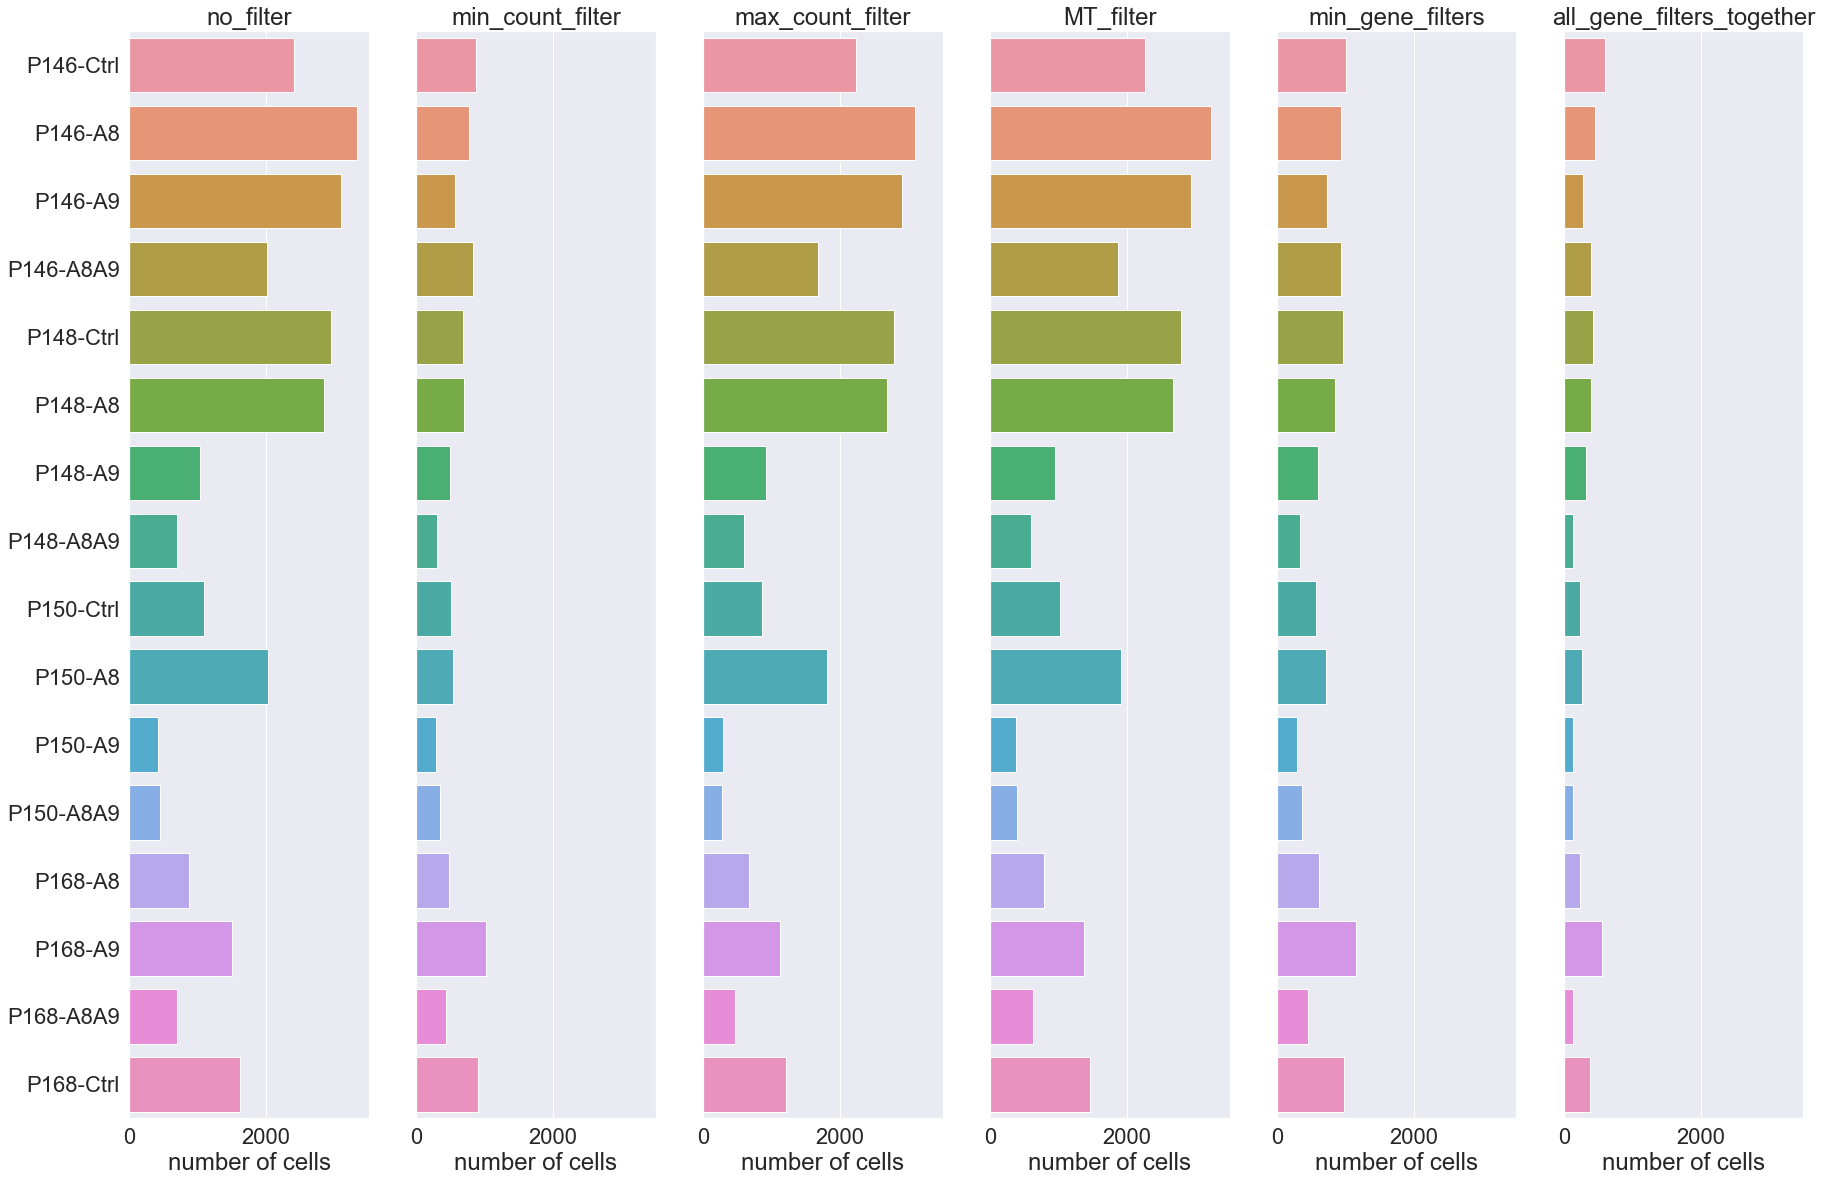

In [24]:
fig, axs = plt.subplots(1,6,figsize=(30,20), sharey=True)
j=0
for tipe in ['no_filter', 'min_count_filter', 'max_count_filter', 'MT_filter',
       'min_gene_filters', 'all_gene_filters_together']:
    sns.barplot(x=tipe, y=pd_cells_per_sample.index, data = pd_cells_per_sample, ax=axs[j], order = pd_cells_per_sample.index)
    axs[j].set_xlim([0,3500])
    axs[j].set_xlabel('number of cells')
    axs[j].set_title(tipe)
    j+=1

In [26]:
for ind in adata_v.obs.internal_id.unique():
    adata_v.obs.loc[adata_v.obs.internal_id==ind, 'patient'] = ind[:4]

In [27]:
# Annotate the data sets
print(adata_v.obs['patient'].value_counts())
print('')
print(adata_v.obs['group'].value_counts())

P146    1703
P168    1275
P148    1263
P150     733
Name: patient, dtype: int64

Ctrl    1619
A8      1315
A9      1270
A8A9     770
Name: group, dtype: int64
